In [1]:
import numpy as np
import torch
from torchvision import transforms
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
import h5py
import os
import sys
from PIL import Image
import glob
#os.chdir('../../../')

In [2]:
!pwd

/home/batman/Documents/cs282a/proj/test_model


# mag2phase

In [3]:
image_number = 116

torch.Size([256, 256])


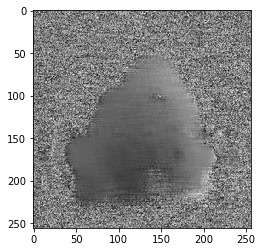

In [4]:
# import ground truth image (PNG))
gt = Image.open('./results/mag2phase_normalize_pix2pix/test_latest/images/'+ str(image_number)+'_real_B.png')
trans1 = transforms.ToTensor()
gt = trans1(gt)[0,:,:]
print(gt.shape)
#torch.equal(gt[2,:,:], gt[1,:,:])
plt.imshow(gt, cmap='gray')

torch.Size([256, 256])


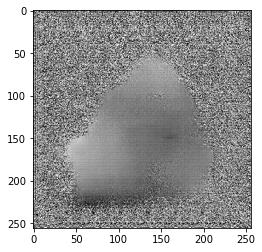

In [5]:
# import generated image
pred = Image.open('./results/mag2phase_normalize_pix2pix/test_latest/images/'+ str(image_number)+'_fake_B.png')
trans1 = transforms.ToTensor()
pred = trans1(pred)[0,:,:]
print(pred.shape)
#torch.equal(pred[0,:,:], pred[2,:,:])
plt.imshow(pred, cmap='gray')

torch.Size([256, 256])
tensor(0.1878)


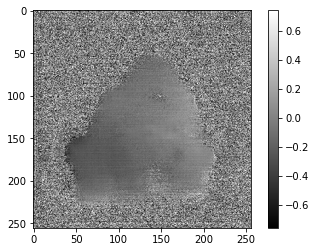

In [6]:
ispace_error = gt - pred
print(ispace_error.shape)
sqerror = torch.pow(ispace_error, 2)
mse = torch.mean(sqerror)
rmse = mse.sqrt()
nrmse = rmse/(pred.max() - pred.min())
print(nrmse)
#plt.imshow(ispace_error, cmap='gray')
plt.imshow(ispace_error, cmap='gray')
plt.colorbar()
plt.show()

### NRMSE calculation over entire test set (mag2phase)

In [7]:
# get nrmse for all images in test set



nrmse_values = []
psnr_values = []

image_directory = '/home/batman/Documents/cs282a/proj/test_model/results/mag2phase_normalize_pix2pix/test_latest/images'

#use glob to make list directory for real and fake B
real_B_list = glob.glob(os.path.join(image_directory, '*_real_B.png'))
fake_B_list = glob.glob(os.path.join(image_directory, '*_fake_B.png'))

for real_B_image, fake_B_image in sorted(zip(real_B_list, fake_B_list)):
   
    gt = Image.open(real_B_image)
    trans1 = transforms.ToTensor()
    gt = trans1(gt)[0,:,:] # single channel; image is same for all 3 channels
    #gt_values = torch.stack(gt_values)


    pred = Image.open(fake_B_image)
    trans1 = transforms.ToTensor()
    pred = trans1(pred)[0:,:,]
    
    # nrmse calculation
    ispace_error = gt - pred
    sqerror = torch.pow(ispace_error, 2)
    mse = torch.mean(sqerror)
    rmse = mse.sqrt()
    nrmse = rmse/(pred.max() - pred.min())
    nrmse_values.append(nrmse)
    
    #psnr calculation
    psnr = 20 * torch.log10(255 / rmse)
    psnr_values.append(psnr)
    
nrmse_values = torch.stack(nrmse_values)
nrmse_values_mean = torch.mean(nrmse_values)

psnr_values = torch.stack(psnr_values)
psnr_values_mean = torch.mean(psnr_values)

print(nrmse_values_mean)
print(psnr_values_mean)

    

tensor(0.2252)
tensor(61.8123)


# mag2kspace visualization

In [3]:
sys.path.append('/home/batman/Documents/cs282a/proj/test_model/fastMRI')
!pwd

/home/batman/Documents/cs282a/proj/test_model


In [4]:
from fastmri.data import transforms, mri_data
from fastmri import ifft2c, complex_abs, fft2c

real_A shape: torch.Size([256, 256])


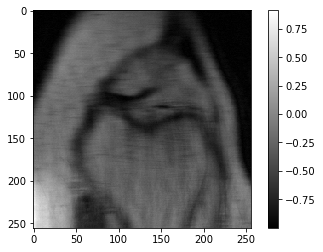

In [69]:
test_directory = '/home/batman/Documents/cs282a/proj/test_model/results/mag2kspace_pix2pix/test_latest/images/'
test1_dict = torch.load(test_directory+'test_3198_dictionary.pt')
real_A = test1_dict['real_A'].detach().cpu()
real_A = real_A.squeeze()
print('real_A shape:', real_A.shape)
plt.imshow(real_A, cmap='gray')
plt.colorbar()
plt.show()

real_B shape: torch.Size([256, 256, 2])


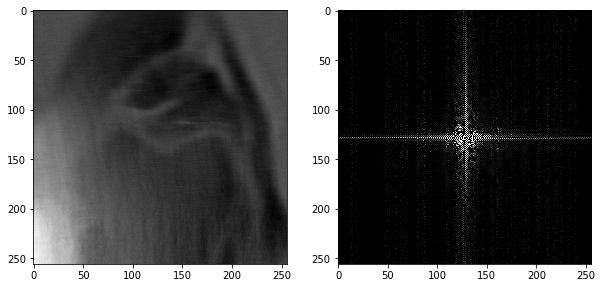

In [70]:
real_B = test1_dict['real_B'].detach().cpu()
real_B = real_B.permute(0,2,3,1)
real_B = real_B.squeeze(0)
print('real_B shape:', real_B.shape)
kspace = real_B
real_B_kspace = fft2c(real_B)
real_B_complex = torch.view_as_complex(real_B_kspace)
#print(fft_form.shape)

f = plt.figure(figsize=(10,6))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
#plt.imshow(fft_form[:,:,1], cmap='gray', vmin=0, vmax=0.5)
ax1.imshow(real_B[:,:,1], cmap='gray')#, vmin=0, vmax=0.5)
# plt.colorbar()
# plt.show()

ax2.imshow(real_B_kspace[:,:,1], cmap='gray', vmin=0, vmax=0.5)

fake_B shape: torch.Size([256, 256, 2])


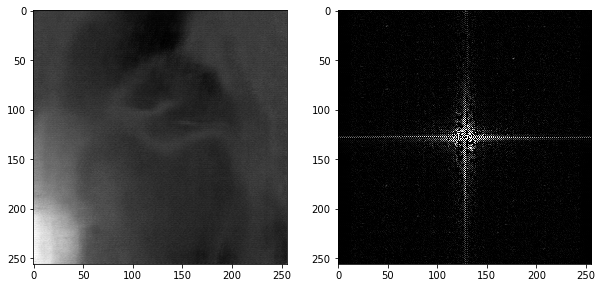

In [71]:
fake_B = test1_dict['fake_B'].detach().cpu()
#print(fake_B.shape)
fake_B = fake_B.permute(0,2,3,1)
fake_B = fake_B.squeeze(0)
print('fake_B shape:', fake_B.shape)
fake_B_kspace = ifft2c(fake_B)
#print(fft_form_fake.shape)
fake_B_complex = torch.view_as_complex(fake_B_kspace)


f = plt.figure(figsize=(10,6))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.imshow(fake_B[:,:,1], cmap='gray')
#plt.imshow(fft_form_fake[:,:,1], cmap='gray', vmin=0, vmax=0.5)
# plt.colorbar()
# plt.show()
ax2.imshow(fake_B_kspace[:,:,1], cmap='gray', vmin=0, vmax=0.5)

### mag2kspace: NRMSE, PSNR, MAE calculation

In [5]:
nrmse_mag_values = []
nrmse_phase_values = []
psnr_mag_values = []
psnr_phase_values = []

error_abs_values = []
error_angle_values = []

test_directory = '/home/batman/Documents/cs282a/proj/test_model/results/mag2kspace_pix2pix/test_latest/images'

#use glob to make list directory for real and fake B
test_list = glob.glob(os.path.join(test_directory, '*.pt'))
for test_image in sorted(test_list):
    
    test_dict = torch.load(test_image)
    
    real_B = test_dict['real_B'].detach().cpu()
    real_B = real_B.permute(0,2,3,1)
    real_B = real_B.squeeze(0)
    real_B_kspace = fft2c(real_B)
    real_B_complex = torch.view_as_complex(real_B_kspace)
    
    fake_B = test_dict['fake_B'].detach().cpu()
    fake_B = fake_B.permute(0,2,3,1)
    fake_B = fake_B.squeeze(0)
    fake_B_kspace = ifft2c(fake_B)
    fake_B_complex = torch.view_as_complex(fake_B_kspace)
    
    # magnitude images
    # nrmse
    ispace_error_mag = (real_B[:,:,0] - fake_B[:,:,0])
    sqerror_mag = torch.pow(ispace_error_mag, 2)
    mse_mag = torch.mean(sqerror_mag)
    rmse_mag = mse_mag.sqrt()
    nrmse_mag = rmse_mag/(fake_B[:,:,0].max() - fake_B[:,:,0].min())
    
    nrmse_mag_values.append(nrmse_mag)
    
    #psnr calculation
    psnr_mag = 20 * torch.log10(255 / rmse_mag)
    psnr_mag_values.append(psnr_mag)
    
    # phase images
    # nrmse
    ispace_error_phase = (real_B[:,:,1] - fake_B[:,:,1])
    sqerror_phase = torch.pow(ispace_error_phase, 2)
    mse_phase = torch.mean(sqerror_phase)
    rmse_phase = mse_phase.sqrt()
    nrmse_phase = rmse_phase/(fake_B[:,:,1].max() - fake_B[:,:,1].min())
    
    nrmse_phase_values.append(nrmse_phase)
    
    #psnr calculation
    psnr_phase = 20 * torch.log10(255 / rmse_phase)
    psnr_phase_values.append(psnr_phase)
    
    
    #kspace abs and angle error
    error_abs = (real_B_complex - fake_B_complex).abs().mean()
    error_angle = torch.abs((real_B_complex - fake_B_complex).angle().mean())
    
    error_abs_values.append(error_abs)
    error_angle_values.append(error_angle)
    
    
nrmse_mag_values = torch.stack(nrmse_mag_values)
nrmse_mag_values_mean = torch.mean(nrmse_mag_values)

nrmse_phase_values = torch.stack(nrmse_phase_values)
nrmse_phase_values_mean = torch.mean(nrmse_phase_values)

psnr_mag_values = torch.stack(psnr_mag_values)
psnr_mag_values_mean = torch.mean(psnr_mag_values)

psnr_phase_values = torch.stack(psnr_phase_values)
psnr_phase_values_mean = torch.mean(psnr_phase_values)

error_abs_values = torch.stack(error_abs_values)
error_abs_values_mean = torch.mean(error_abs_values)

error_angle_values = torch.stack(error_angle_values)
error_angle_values_mean = torch.mean(error_angle_values)


print(nrmse_mag_values_mean)
print(nrmse_phase_values_mean)
print(psnr_mag_values_mean)
print(psnr_phase_values_mean)
print(error_abs_values_mean)
print(error_angle_values_mean)

tensor(0.0479)
tensor(0.0757)
tensor(73.0349)
tensor(69.4836)
tensor(0.0831)
tensor(0.0279)
